## imports

In [4]:
%matplotlib inline

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

import sys
from pathlib2 import Path

# NOTE these two lines (especially the second one) are somewhat dangerous 
# and you'd better just add path to this repo to PYTHONPATH
# but this should work!
sys.path.append(Path.cwd().parent.as_posix())
sys.path.append(Path.cwd().parent.parent.as_posix())

In [6]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams["font.size"] = 14

from nn_stochvol import paths, load_surfaces, training, dplot, utils,  lbfgs_wrapper

## loading model

In [7]:
TYPE = "new"

In [8]:
model         = torch.load(str(paths.PATH_TO_MODELS/f"model_{TYPE}.pt"))
vol_scaler    = torch.load(str(paths.PATH_TO_MODELS/f"vol_scaler_{TYPE}.pt"))
params_scaler = torch.load(str(paths.PATH_TO_MODELS/f"params_scaler_{TYPE}.pt"))
bounds        = torch.load(str(paths.PATH_TO_MODELS/f"bounds_{TYPE}.pt"))


## Load some target_vlt_surf

In [9]:
paths_to_real_surf = [str(x) for x in paths.PATH_TO_REAL_DATA.glob("*")]

In [10]:
paths_to_real_surf

['/home/alexander/nn_stochvol/data/real_vol_surfaces/spxVols20171215.csv',
 '/home/alexander/nn_stochvol/data/real_vol_surfaces/spxVols20170519.csv',
 '/home/alexander/nn_stochvol/data/real_vol_surfaces/spxVols20171212.csv',
 '/home/alexander/nn_stochvol/data/real_vol_surfaces/spxVols20171214.csv',
 '/home/alexander/nn_stochvol/data/real_vol_surfaces/spxVols20171211.csv',
 '/home/alexander/nn_stochvol/data/real_vol_surfaces/spxVols20171213.csv',
 '/home/alexander/nn_stochvol/data/real_vol_surfaces/spxVols20100204.csv',
 '/home/alexander/nn_stochvol/data/real_vol_surfaces/spxVols20130814.csv']

In [11]:
DATES_YYYYMMDD = sorted([int(x[-12:-4]) for x in paths_to_real_surf])
DATES_YYYYMMDD

[20100204,
 20130814,
 20170519,
 20171211,
 20171212,
 20171213,
 20171214,
 20171215]

In [12]:
# 20100204                 # -0.9 1.9  0.07 
DATE_YYYYMMDD   = 20130814 # -0.9 2.3 0.05 
vlt_surf_ms, df_vlt_surf, maturities_ms, strikes_ms = load_surfaces.get_vlt_surf_ms_from_real_data(DATE_YYYYMMDD, data_type=TYPE)

## creating optimizer

In [13]:
params_optimizer = training.ParamsOptimizer(model, params_scaler=params_scaler, vol_scaler=vol_scaler)

optimal_params, pred_vlt_surf_ms, target_vlt_surf_ms = params_optimizer.optimize(
    target_vlt_surf=vlt_surf_ms,
    bounds=bounds)

No handles with labels found to put in legend.


,eta,rho,H
20130814,2.310935,-0.67655,0.09941


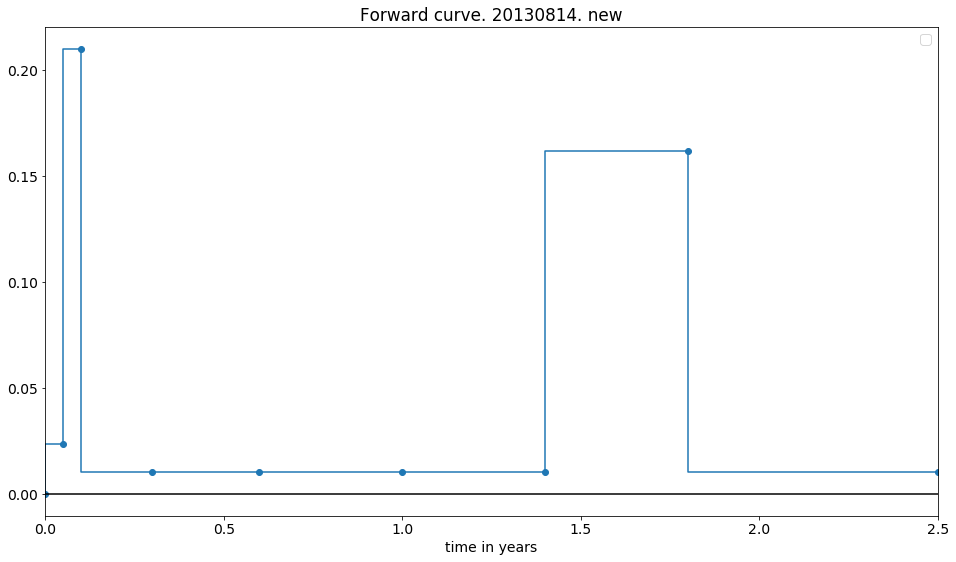

In [15]:
df_params, axis = dplot.plot_params(optimal_params, data_type=TYPE, label=DATE_YYYYMMDD)
df_params

## creating dataframe with parameters for comparison

In [16]:
list_of_optimal_params = []
for date in DATES_YYYYMMDD:
    vlt_surf_ms, df_vlt_surf, maturities_ms, strikes_ms = load_surfaces.get_vlt_surf_ms_from_real_data(date, data_type=TYPE)
    params_optimizer = training.ParamsOptimizer(model, params_scaler=params_scaler, vol_scaler=vol_scaler)

    optimal_params, pred_vlt_surf_ms, target_vlt_surf_ms = params_optimizer.optimize(
        target_vlt_surf=vlt_surf_ms,
        bounds=bounds)
    
    list_of_optimal_params.append(optimal_params)
    

params_dataset = pd.DataFrame(
    data=list_of_optimal_params,
    columns=[f"ksi_{i}" for i in range(1, 9)] + ["eta", "rho", "H"],
    index=DATES_YYYYMMDD)

params_dataset.to_csv(f"../images/optimal_params_{TYPE}.csv")

In [36]:
params_dataset.to_html(f"../images/table_{TYPE}.html")
import subprocess
subprocess.call(f'wkhtmltoimage -f png --width 0 ../images/table_{TYPE}.html ../images/table_{TYPE}.png', shell=True)

127

## plotting for 20130814

<IPython.core.display.Javascript object>


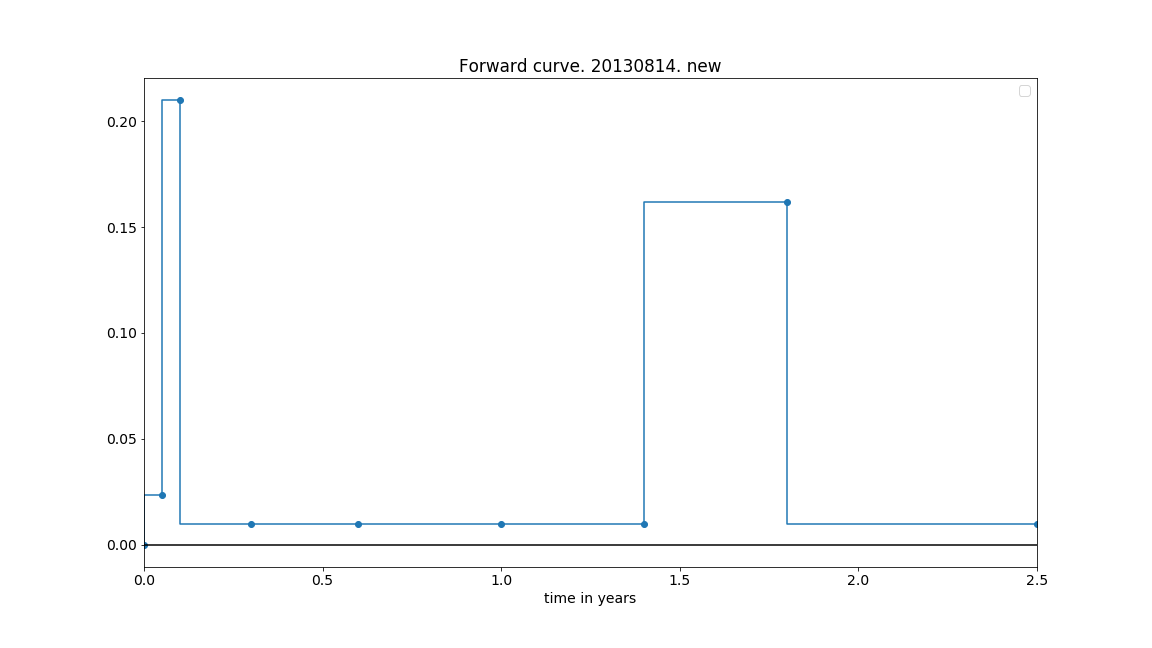

No handles with labels found to put in legend.


,eta,rho,H
20130814,2.310935,-0.67655,0.09941


In [37]:
# 20100204                 # -0.9 1.9  0.07 
DATE_YYYYMMDD   = 20130814 # -0.9 2.3 0.05 
vlt_surf_ms, df_vlt_surf, maturities_ms, strikes_ms = load_surfaces.get_vlt_surf_ms_from_real_data(DATE_YYYYMMDD, data_type=TYPE)

params_optimizer = training.ParamsOptimizer(model, params_scaler=params_scaler, vol_scaler=vol_scaler)

optimal_params, pred_vlt_surf_ms, target_vlt_surf_ms = params_optimizer.optimize(
    target_vlt_surf=vlt_surf_ms,
    bounds=bounds)

df_params, axis = dplot.plot_params(optimal_params, data_type=TYPE, label=DATE_YYYYMMDD)
df_params

In [24]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook

<IPython.core.display.Javascript object>


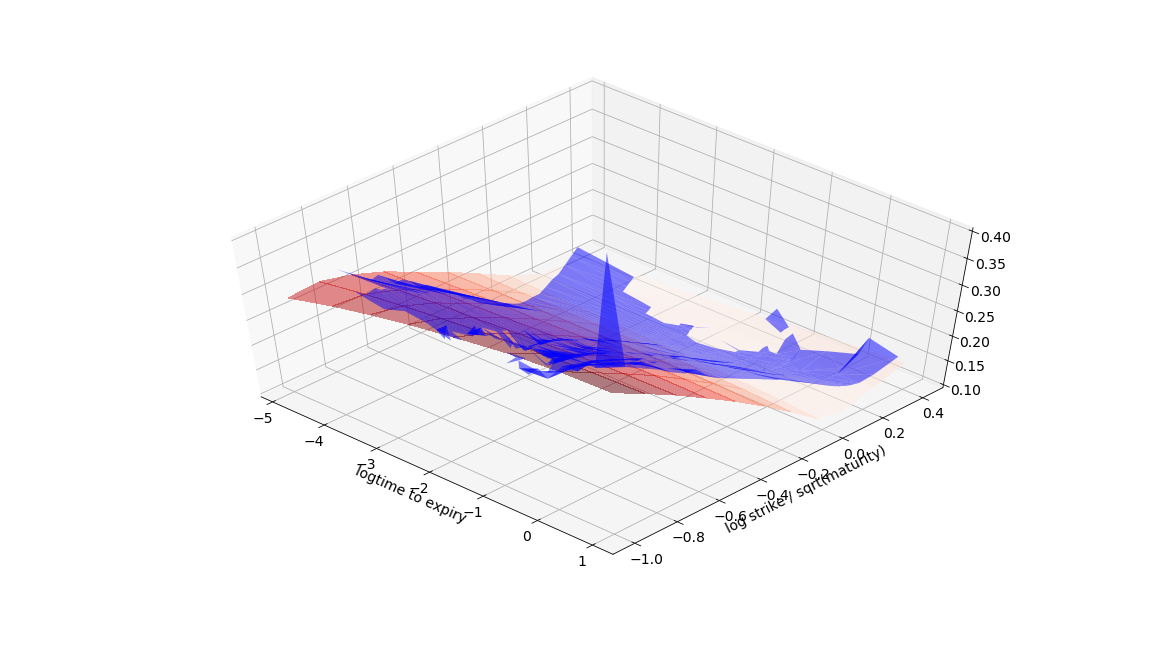

(0.1, 0.4)

In [38]:
import matplotlib.cm as cm
plot_kwargs = {
    "log_mat_tk" : True,
    "log_and_sqrt_strike_tk" : True,
}

# plot_kwargs = {
#     "log_mat_tk" : False,
#     "log_and_sqrt_strike_tk" : False,
# }



fig, axis = dplot.get_fig_axis_3d()

dplot.plot_vol_surface(maturities_ms, strikes_ms,
                       pred_vlt_surf_ms, axis=axis,  cmap=cm.Reds, **plot_kwargs)

# dplot.plot_vol_surface(raw_data["mat_ms"], raw_data["strikes_ms"],
#                        jims_proposal_for_20130814.values - 0.15, axis=axis, label="1", cmap=cm.Reds, **plot_kwargs)


# dplot.plot_vol_surface(raw_data["mat_ms"], raw_data["strikes_ms"],
#                        target_vlt_surf_ms, axis=axis, label="1", cmap=cm.Reds, **plot_kwargs)


dplot.plot_vol_surface_from_real_data(df_vlt_surf, axis=axis, cmap=cm.winter, **plot_kwargs)
axis.set_zlim(0.1, 0.4)

In [40]:
axis.get_figure().savefig(f"../images/3d_plot_{TYPE}.png")